In [54]:
import pandas as pd
import numpy as np

In [55]:
d=pd.read_csv('/home/salmon/workspace/data/15MA inductive - burn/profile.txt',sep='\t')

In [57]:
d["rho"]

0      0.008843
1      0.026530
2      0.044220
3      0.061900
4      0.079590
         ...   
148    2.626000
149    2.644000
150    2.662000
151    2.680000
152    2.697000
Name: rho, Length: 153, dtype: float64

In [1]:
import sys
sys.path.append("/home/salmon/workspace/fytok/python")
sys.path.append("/home/salmon/workspace/fytok/external/SpDB/python")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fytok.Tokamak import Tokamak
from spdm.data.Collection import Collection
from spdm.data.File import File
from spdm.numerical.Function import Function
from spdm.util.logger import logger
from spdm.util.plot_profiles import plot_profiles

2021-04-08 12:20:20,655 DEBUG [spdm] /home/salmon/workspace/fytok/external/SpDB/python/spdm/numerical/Function.py:16:<module>: Using SciPy Version: 1.4.1


In [3]:
device = File("/home/salmon/workspace/fytok/data/mapping/ITER/imas/3/static/config.xml").entry

equilibrium = File(
        "/home/salmon/workspace/fytok/examples/data/NF-076026/geqdsk_550s_partbench_case1",
        # "/home/salmon/workspace/data/15MA inductive - burn/Increased domain R-Z/High resolution - 257x513/g900003.00230_ITER_15MA_eqdsk16VVHR.txt",
        # "/home/salmon/workspace/data/Limiter plasmas-7.5MA li=1.1/Limiter plasmas 7.5MA-EQDSK/Limiter_7.5MA_outbord.EQDSK",
        format="geqdsk").entry

tok = Tokamak({
        "radial_grid": {
            "axis": 128,
            "label": "rho_tor_norm"
        },
        "wall":  device.wall,
        "pf_active": device.pf_active,
        "equilibrium": {
            "vacuum_toroidal_field": equilibrium.vacuum_toroidal_field,
            "global_quantities": equilibrium.global_quantities,
            "profiles_1d": equilibrium.profiles_1d,
            "profiles_2d": equilibrium.profiles_2d,
            "coordinate_system": {"grid": {"dim1": 64, "dim2": 128}}
        },
        # "core_profiles":{ion": [{}]}
    })

rho_tor_norm = np.linspace(0, 1.0, 128)


2021-04-08 12:20:21,553 DEBUG [spdm] /home/salmon/workspace/fytok/external/SpDB/python/spdm/data/file/PluginXML.py:71:load_xml: Loading XML file from /home/salmon/workspace/fytok/data/mapping/ITER/imas/3/static/config.xml
2021-04-08 12:20:21,555 DEBUG [spdm] /home/salmon/workspace/fytok/external/SpDB/python/spdm/data/file/PluginXML.py:71:load_xml: Loading XML file from /home/salmon/workspace/fytok/data/mapping/ITER/imas/3/static/wall.xml
2021-04-08 12:20:21,557 DEBUG [spdm] /home/salmon/workspace/fytok/external/SpDB/python/spdm/data/file/PluginXML.py:71:load_xml: Loading XML file from /home/salmon/workspace/fytok/data/mapping/ITER/imas/3/static/pf_active.xml


In [45]:

r_ped = np.sqrt(0.88)
n_src = Function(rho_tor_norm, lambda x: 7.5e20 * np.exp(15.0*(x**2-1.0)))
diff = Function(rho_tor_norm,
                [lambda r:r < r_ped, lambda r:r >= r_ped],
                [lambda x:0.5 + (x**4), lambda x: 0.11])

conv = -diff*rho_tor_norm * 1.385 / equilibrium.vacuum_toroidal_field.r0

tok.initialize({
    "r_ped": r_ped,  # \frac{\Phi}{\Phi_a}=0.88
    "electron": {
        "density": {
            "n0": Function(rho_tor_norm, np.full(rho_tor_norm.shape, 1e20)),
            "source": n_src,
            "diffusivity":  diff,
            "pinch": conv,
            "boundary_condition": {"value": 4.6e19}
        },
        "temperature": {
            "T0": 0.95e19,
            "profile": lambda r: (1-r**2)**2,
        }}
})


In [46]:
tok.update(transport_solver={})

2021-04-08 13:00:30,783 DEBUG [spdm] /home/salmon/workspace/fytok/python/fytok/Tokamak.py:278:update: time=0.0  iterator step 0/1
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.90e-04       0.00e+00          128             0       
Solved in 1 iterations, number of nodes 128. 
Maximum relative residual: 1.90e-04 
Maximum boundary residual: 0.00e+00
2021-04-08 13:00:30,951 INFO [spdm] : Solve transport equations: Electron density: Success 


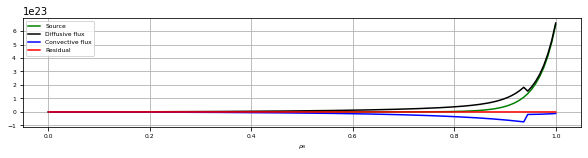

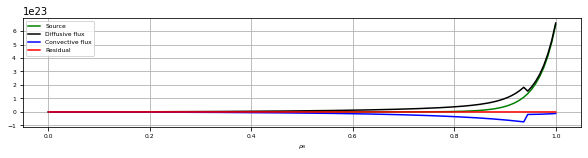

In [47]:
plot_profiles([  
[
    (tok.core_profiles.electrons.n_s_exp_flux,    {"color": "green", "label": r"Source"}),
    (tok.core_profiles.electrons.n_diff_flux,     {"color": "black", "label": r"Diffusive flux"}),
    (tok.core_profiles.electrons.n_conv_flux,     {"color": "blue",  "label": r"Convective flux"}),
    (tok.core_profiles.electrons.n_residual,      {"color": "red",   "label": r"Residual"}),
]
], x_axis=(tok.core_profiles.electrons.density.x,   {"label": r"$\rho_{N}$"}),  # x axis,
grid=True) 

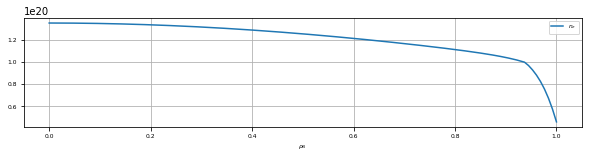

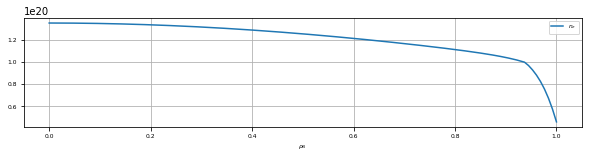

In [48]:
plot_profiles(
    [  
        (tok.core_profiles.electrons.density,             r"$n_{e}$"),
    ],
    x_axis=(tok.core_profiles.electrons.density.x,   {"label": r"$\rho_{N}$"}),  # x axis,
    grid=True) 

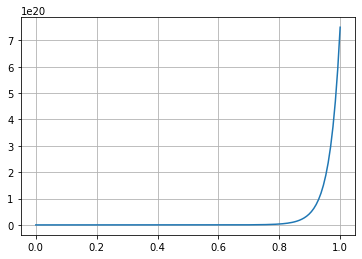

In [53]:
plt.plot(rho_tor_norm,n_src)
plt.grid()